## Calculate the skill of a MJO Index as a function of lead time from the S2S project

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [1]:
import xarray as xr
xr.set_options(display_style='html')

In [144]:
import matplotlib.pyplot as plt
from climpred import HindcastEnsemble
import climpred
import numpy as np

IRIDL hosts various subseasonal initialized forecast and hindcast simulations:
- `S2S project`:
    - http://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/
        - hindcast/reforecast: one variable, one model: ~ 80 GB
        - login required
- `SubX project`:
    - http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/
        - hindcast/reforecast: one variable, one model: ~ 100 GB
        - login not required

---

Here, we demonstrate how to set a cookie for IRIDL and access the skill of RMM1 subseasonal reforecasts.

---

Here are instructions for configuring xarray to open protected Data Library datasets, after you have created a Data Library account and accepted the terms and conditions for the dataset.
1. Visit https://iridl.ldeo.columbia.edu/auth/genkey . Log in to the Data Library. Copy the key from the response.

2. Create a file with the following content, substituting the key from step 1 for `"xxxx"`:
`Set-Cookie: __dlauth_id=xxxx; domain=.iridl.ldeo.columbia.edu`

3. Put the following in `~/.daprc`, which is `/home/jovyan/.daprc` on renku, substituting the path to the above file for `/path/to/cookie/file`:
`HTTP.COOKIEJAR=/path/to/cookie/file`. You may need to copy `.daprc` to `/home/jovyan` on renku, because `/home/jovyan` is not tracked by `git`.

In [2]:
!cat ~/.daprc

HTTP.COOKIEJAR=/Users/aaron.spring/.cookie_iridl


In [3]:
#%writefile ~/.cookie_iridl
#Set-Cookie: __dlauth_id=xxxx; domain=.iridl.ldeo.columbia.edu

In [278]:
# observations
obsds = climpred.tutorial.load_dataset('RMM-INTERANN-OBS')['rmm1'].to_dataset()
obsds = obsds.dropna('time').sel(time=slice('1995',None)) # Get rid of missing times.

## "on-the-fly" reforecasts
S2S models:
- ECMF
- ECCC
- ...

There are a set of reforecasts of the ECMWF model that match each real time forecast. They are made "on the fly" when a real time forecast is issued. So for S=0000 8 Feb 2021, there are reforecasts initialized on 0000 8 Feb 2020 and the 19 previous years on 8 Feb.

In [7]:
%%time
ds = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.RMMS/.ensembles/.RMM1/dods',
                    decode_times=False, chunks=None).compute()

CPU times: user 3.21 s, sys: 6.24 s, total: 9.45 s
Wall time: 13min 13s


In [ ]:
# calendar '360' not recognized, but '360_day'
if ds.hdate.attrs['calendar']=='360':
    ds.hdate.attrs['calendar']='360_day'

In [16]:
fcstds = ds.rename({'S': 'init','L': 'lead','M': 'member', 'RMM1' : 'rmm1'})

In [277]:
fcstds['lead'] = np.arange(1,1+fcstds['lead'].size)
fcstds['lead'].attrs={'units': 'days'}

In [ ]:
fcstds = xr.decode_cf(fcstds)
fcstds.coords

In [325]:
fcstds.coords

Coordinates:
  * init     (init) object 2015-05-14 00:00:00 ... 2021-02-15 00:00:00
  * member   (member) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 ... 37 38 39 40 41 42 43 44 45 46
  * hdate    (hdate) object 1995-07-01 00:00:00 ... 2020-07-01 00:00:00

The S2S data dimensions correspond to the following `climpred` dimension definitions: `M=member`, `S=init`.  We will rename the dimensions to their `climpred` names.

In [217]:
#fcstds.to_netcdf('fcstds.nc')

# save time
fcstds = xr.open_dataset('fcstds.nc',use_cftime=True)

### Skill for a single `init.dayofyear`

In [337]:
fcstds.coords

Coordinates:
  * init     (init) object 2015-05-14 00:00:00 ... 2021-02-15 00:00:00
  * member   (member) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 ... 37 38 39 40 41 42 43 44 45 46
  * hdate    (hdate) object 1995-07-01 00:00:00 ... 2020-07-01 00:00:00

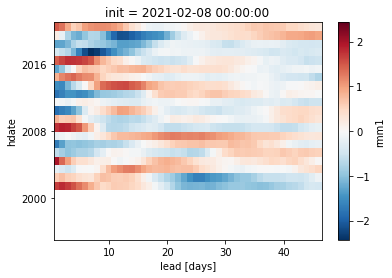

In [330]:
d='08'
m='02'
y='2021'

fcstds.sel(init=f'{y}-{m}-{d}').squeeze().rmm1.mean('member').plot()

In [339]:
import cftime
# create a new init coordinate
new_init = xr.concat([xr.DataArray(cftime.DatetimeProlepticGregorian(int(h.dt.year.values),int(m),int(d))) for h in fcstds.hdate],'init')

# select new inits for same dayofyear, drop all NaNs
fcstds_date = fcstds.sel(init=f'{y}-{m}-{d}',drop=True).squeeze(drop=True).assign_coords(hdate=new_init).rename({'hdate':'init'}).dropna('init',how='all')

In [340]:
hindcast = HindcastEnsemble(fcstds_date)
hindcast = hindcast.add_observations(obsds)


In [341]:
%time skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')

CPU times: user 1.57 s, sys: 24.9 ms, total: 1.6 s
Wall time: 1.64 s


Text(0.5, 1.0, 'RMM1 daily initialized 02-08 ACC \n reforecasts: 2001-2020')

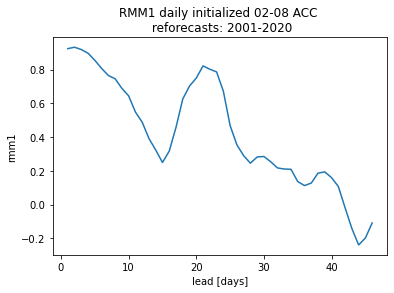

In [342]:
skill.rmm1.plot()
plt.title(f'RMM1 daily initialized {m}-{d} ACC')

### skill over all inits
create large dataarray with all `hdate` stacked into `init`

In [343]:
fcstds_dates=[]
for s in fcstds.init:
    d=str(s.init.dt.day.values).zfill(2)
    m=str(s.init.dt.month.values).zfill(2)
    y=s.init.dt.year.values
    if d=='29' and m=='02':
        continue
    new_init = xr.concat([xr.DataArray(cftime.DatetimeProlepticGregorian(int(h.dt.year.values),int(m),int(d))) for h in fcstds.hdate],'init')
    # select new inits for same dayofyear, drop all NaNs
    fcstds_date = fcstds.sel(init=f'{y}-{m}-{d}',drop=True).squeeze(drop=True).assign_coords(hdate=new_init).rename({'hdate':'init'}).dropna('init',how='all')
    if fcstds_date.init.size > 0:
        fcstds_dates.append(fcstds_date)
        #print('add',d,m,y)

In [344]:
fcstds_dates = xr.concat(fcstds_dates, 'init')

In [345]:
fcstds_dates = fcstds_dates.sortby(fcstds_dates.init)

In [346]:
# drop duplicates, unnecessary?
#_, index = np.unique(fcstds_dates.init, return_index=True)
#fcstds_dates = fcstds_dates.isel(init=index)

In [347]:
hindcast = HindcastEnsemble(fcstds_dates)
hindcast = hindcast.add_observations(obsds)

/Users/aaron.spring/Coding/climpred/climpred/classes.py:380: UserWarning: Error due to verification/control/uninitialized: xr.sel((), {'init': slice('2000', '2001', None)}) failed
ValueError: dimensions or multi-index levels ['init'] do not exist
  warnings.warn(


CPU times: user 1min 22s, sys: 690 ms, total: 1min 23s
Wall time: 1min 27s


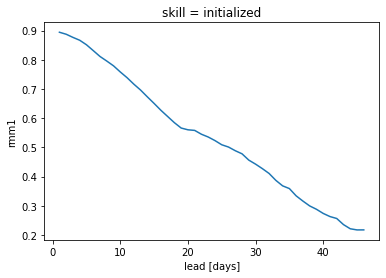

In [348]:
%time skill = hindcast.sel(init=slice('2000','2001')).verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')

skill.rmm1.plot()

### skill when initialized in different months

/Users/aaron.spring/Coding/climpred/climpred/classes.py:380: UserWarning: Error due to verification/control/uninitialized: xr.sel((), {'init': <xarray.DataArray 'month' (init: 12020)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * init     (init) object 1995-05-14 00:00:00 ... 2020-02-15 00:00:00}) failed
ValueError: dimensions or multi-index levels ['init'] do not exist
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/classes.py:380: UserWarning: Error due to verification/control/uninitialized: xr.sel((), {'init': <xarray.DataArray 'month' (init: 12020)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * init     (init) object 1995-05-14 00:00:00 ... 2020-02-15 00:00:00}) failed
ValueError: dimensions or multi-index levels ['init'] do not exist
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/classes.py:380: UserWarning: Error due to verification/control/uninitialized: xr.sel((), {'init': <xarray.DataArray 'month'

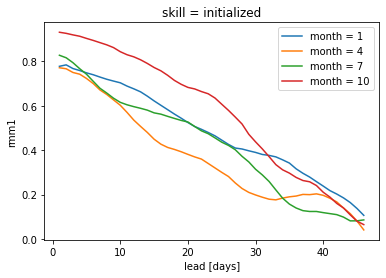

In [355]:
for m in np.arange(1,13,3):
    skill = hindcast.sel(init=fcstds_dates.init.dt.month==m).verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
    skill.rmm1.plot(label=f'month = {m}')
plt.legend()

### skill over certain `init.dayofyear`

/Users/aaron.spring/Coding/climpred/climpred/classes.py:380: UserWarning: Error due to verification/control/uninitialized: xr.sel((), {'init': <xarray.DataArray 'dayofyear' (init: 12020)>
array([False, False, False, ...,  True, False, False])
Coordinates:
  * init     (init) object 1995-05-14 00:00:00 ... 2020-02-15 00:00:00}) failed
ValueError: dimensions or multi-index levels ['init'] do not exist
  warnings.warn(


CPU times: user 4.04 s, sys: 55.5 ms, total: 4.1 s
Wall time: 4.45 s


Text(0.5, 1.0, 'RMM1 daily initialized 2-8 ACC \n reforecasts: 1996-2020')

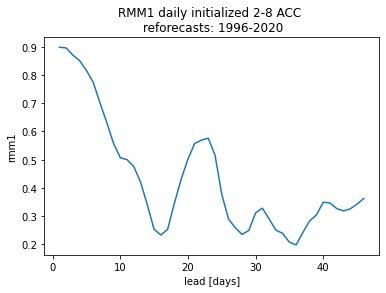

In [349]:
# take 39th dayofyear, i.e. feb 8 only
hindcast2 = hindcast.sel(init=hindcast.get_initialized().init.dt.dayofyear==39)
%time skill = hindcast2.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')
skill.rmm1.plot()
i = hindcast2.get_initialized().init
m = int(i.dt.month[0].values)
d = int(i.dt.day[0].values)
plt.title(f'RMM1 daily initialized {m}-{d} ACC')

## models without "on-the-fly" reforecasts
very similar workflow as in the `SubX` examples as there is no `hdate` coordinate

S2S models:
- CRNM
- ...

In [372]:
ds = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.CNRM/.reforecast/.RMMS/.ensembles/.RMM1/dods', decode_times=True).compute()

ds = ds.dropna('S',how='all')

In [373]:
fcstds = ds.rename({'S': 'init','L': 'lead','M': 'member', 'RMM1' : 'rmm1'})
fcstds['lead'] = np.arange(1,1+fcstds['lead'].size)
fcstds['lead'].attrs={'units': 'days'}

In [374]:
hindcast = HindcastEnsemble(fcstds)
hindcast = hindcast.add_observations(obsds)

In [375]:
%time skill = hindcast.verify(metric='acc', comparison='e2o', dim='init', alignment='maximize')

CPU times: user 43.2 s, sys: 299 ms, total: 43.5 s
Wall time: 45.2 s


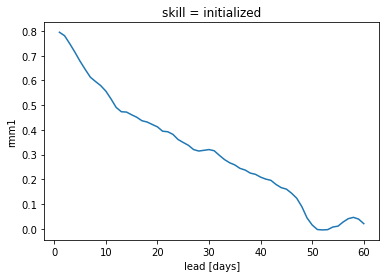

In [376]:
skill.rmm1.plot()